# Ciência de Dados - Trabalho Prático

> **Nomes:** Bruno Santos Fernandes, João Paulo Moura Clevelares, Thamya Vieira Hashimoto Donadia <br>
> **Matrículas:** 2021100784, 2021100149, 2021100146 <br>
> **E-mails:** {bruno.s.fernandes, joao.clevelares, thamya.donadia}@edu.ufes.br <br>
> **Curso:** Engenharia de Computação <br>


## Introdução

O objetivo geral deste trabalho é praticar os conceitos discutidos em sala de aula, principalmente: representação e pré-processamento de dados textuais, redução de dimensionalidade e algoritmos de agrupamento.

##### Dados

Para esse trabalho utilizamos um conjunto de dados de filmes. Os dados foram obtidos de várias fontes, incluindo IMDB.

Os dados estão organizados um arquivo (`.csv`) com as seguintes colunas:

* **genres** - gêneros a que um filme pertence. Veja que um filme pode estar associado a mais de um gênero (`str`);
* **sinopse** - sinopse do filme (`str`);
* **startYear** - ano de lançamento do filme (`int`);
* **primaryTitle** - título do filme (`str`);
* **runtimeMinutes** - duração do filme, em minutos (`int`);
* **averageRating** - média das avaliações do filme (`float`);
* **numVotes** - número de avaliações do filme (`int`);
* **actors_names** - atores/atrizes principais (`str`);
* **directors_names** - diretores(as) do filme (`str`).

**Observação:** esse conjunto de dados é uma versão transformada dos dados originais. Por exemplo, gêneros muito populares ou raros foram removidos.

##### Objetivo

Utilizar aprendizado não supervisionado (neste caso, agrupamento) para investigar se há relação entre a **sinopse** de um filme e o(s) **gênero(s)** a que pertence.

De forma mais específica, vocês deverão agrupar os filmes de acordo suas sinopses e, após isso, verificar a distribuição dos gêneros em cada grupo. Ou seja, se os filmes pertencentes ao mesmo grupo possuem o(s) mesmo(s) gênero(s) ou se as distribuições de gêneros de grupos diferentes são distintas.

## Metodologia

Para atingir o objetivo proposto, vocês deverão seguir ao menos os seguintes passos:
1. Pré-processamento dos dados textuais;
2. Construção da matriz de TF-IDF;
3. Redução de dimensionalidade, via *Truncated SVD*: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
4. Normalização;
5. Aplicação do KMeans;
6. Aplicação do Agrupamento Espectral;
7. LDA ?
8. Validação da metodologia utilizada;
9. Interpretação dos resultados.

## Desenvolvimento

### Bibliotecas

In [4]:
# importação de bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import unidecode
import string
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')
from numpy import linalg as LA

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph

from sklearn.cluster import KMeans

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jp_mo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jp_mo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Ajustes e Parâmetros

In [5]:
MIN_DF=2
K_KMEANS=8
K_SPECTRAL=8
SAMPLE_SIZE=0.2  # %
SVD_DIMENSION=2500

### Execução

#### Pré-processamento dos dados textuais

In [6]:
# carregamento do dataset 
df = pd.read_csv("./filmes.csv")
df.head()

,genres,averageRating,numVotes,sinopse,primaryTitle,startYear,runtimeMinutes,actors_names,directors_names
0,Family,7.1,387992,When two kids find and play a magical board ga...,Jumanji,1995,104,['Robin Williams' 'Jonathan Hyde' 'Jonathan Hy...,['Joe Johnston']
1,Romance,6.7,30265,John and Max resolve to save their beloved bai...,Grumpier Old Men,1995,101,['Walter Matthau' 'Jack Lemmon' 'Burgess Mered...,['Howard Deutch']
2,Romance,6.0,12585,"Based on Terry McMillan's novel, this film fol...",Waiting to Exhale,1995,124,['Gregory Hines' 'Dennis Haysbert' 'Mykelti Wi...,['Forest Whitaker']
3,"Romance,Family",6.1,42555,George Banks must deal not only with his daugh...,Father of the Bride Part II,1995,106,['Steve Martin' 'Martin Short' 'George Newbern...,['Charles Shyer']
4,"Crime,Action",8.3,738636,A group of high-end professional thieves start...,Heat,1995,170,['Al Pacino' 'Robert De Niro' 'Val Kilmer' 'Jo...,['Michael Mann']


In [7]:
# obtenção das informações gerais do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30358 entries, 0 to 30357
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   genres           30358 non-null  object 
 1   averageRating    30358 non-null  float64
 2   numVotes         30358 non-null  int64  
 3   sinopse          30358 non-null  object 
 4   primaryTitle     30358 non-null  object 
 5   startYear        30358 non-null  int64  
 6   runtimeMinutes   30358 non-null  object 
 7   actors_names     30358 non-null  object 
 8   directors_names  30358 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 2.1+ MB


In [8]:
# verificando as features do dataset
df.columns

Index(['genres', 'averageRating', 'numVotes', 'sinopse', 'primaryTitle',
       'startYear', 'runtimeMinutes', 'actors_names', 'directors_names'],
      dtype='object')

In [9]:
# obtendo a feature a ser processada (sinopse)
df['sinopse'].head(10)

0    When two kids find and play a magical board ga...
1    John and Max resolve to save their beloved bai...
2    Based on Terry McMillan's novel, this film fol...
3    George Banks must deal not only with his daugh...
4    A group of high-end professional thieves start...
5    An ugly duckling having undergone a remarkable...
6    A former fireman takes on a group of terrorist...
7    When a powerful secret defense system is stole...
8    A widowed U.S. President running for reelectio...
9    Mel Brooks' parody of the classic vampire stor...
Name: sinopse, dtype: object

In [10]:
# divisão do texto em sentenças e palavras
df['sentences'] = df['sinopse'].apply(sent_tokenize)
df['tokens'] = df['sinopse'].apply(word_tokenize)

df.head()

,genres,averageRating,numVotes,sinopse,primaryTitle,startYear,runtimeMinutes,actors_names,directors_names,sentences,tokens
0,Family,7.1,387992,When two kids find and play a magical board ga...,Jumanji,1995,104,['Robin Williams' 'Jonathan Hyde' 'Jonathan Hy...,['Joe Johnston'],[When two kids find and play a magical board g...,"[When, two, kids, find, and, play, a, magical,..."
1,Romance,6.7,30265,John and Max resolve to save their beloved bai...,Grumpier Old Men,1995,101,['Walter Matthau' 'Jack Lemmon' 'Burgess Mered...,['Howard Deutch'],[John and Max resolve to save their beloved ba...,"[John, and, Max, resolve, to, save, their, bel..."
2,Romance,6.0,12585,"Based on Terry McMillan's novel, this film fol...",Waiting to Exhale,1995,124,['Gregory Hines' 'Dennis Haysbert' 'Mykelti Wi...,['Forest Whitaker'],"[Based on Terry McMillan's novel, this film fo...","[Based, on, Terry, McMillan, 's, novel, ,, thi..."
3,"Romance,Family",6.1,42555,George Banks must deal not only with his daugh...,Father of the Bride Part II,1995,106,['Steve Martin' 'Martin Short' 'George Newbern...,['Charles Shyer'],[George Banks must deal not only with his daug...,"[George, Banks, must, deal, not, only, with, h..."
4,"Crime,Action",8.3,738636,A group of high-end professional thieves start...,Heat,1995,170,['Al Pacino' 'Robert De Niro' 'Val Kilmer' 'Jo...,['Michael Mann'],[A group of high-end professional thieves star...,"[A, group, of, high-end, professional, thieves..."


In [11]:
# conversão do texto para letras minúsculas
df['tokens'] = df['tokens'].apply(lambda x: [token.lower() for token in x])
df['tokens'].head(10)

0    [when, two, kids, find, and, play, a, magical,...
1    [john, and, max, resolve, to, save, their, bel...
2    [based, on, terry, mcmillan, 's, novel, ,, thi...
3    [george, banks, must, deal, not, only, with, h...
4    [a, group, of, high-end, professional, thieves...
5    [an, ugly, duckling, having, undergone, a, rem...
6    [a, former, fireman, takes, on, a, group, of, ...
7    [when, a, powerful, secret, defense, system, i...
8    [a, widowed, u.s., president, running, for, re...
9    [mel, brooks, ', parody, of, the, classic, vam...
Name: tokens, dtype: object

In [12]:
# remoção de símbolos de pontuação de cada token
table = str.maketrans('', '', string.punctuation)
df['tokens'] = df['tokens'].apply(lambda x: [token.translate(table) for token in x])
df['tokens'].head(10)

0    [when, two, kids, find, and, play, a, magical,...
1    [john, and, max, resolve, to, save, their, bel...
2    [based, on, terry, mcmillan, s, novel, , this,...
3    [george, banks, must, deal, not, only, with, h...
4    [a, group, of, highend, professional, thieves,...
5    [an, ugly, duckling, having, undergone, a, rem...
6    [a, former, fireman, takes, on, a, group, of, ...
7    [when, a, powerful, secret, defense, system, i...
8    [a, widowed, us, president, running, for, reel...
9    [mel, brooks, , parody, of, the, classic, vamp...
Name: tokens, dtype: object

In [13]:
# conversão de caracteres especiais
df['tokens'] = df['tokens'].apply(lambda x: [unidecode.unidecode(token) for token in x])
df['tokens'].head(10)


0    [when, two, kids, find, and, play, a, magical,...
1    [john, and, max, resolve, to, save, their, bel...
2    [based, on, terry, mcmillan, s, novel, , this,...
3    [george, banks, must, deal, not, only, with, h...
4    [a, group, of, highend, professional, thieves,...
5    [an, ugly, duckling, having, undergone, a, rem...
6    [a, former, fireman, takes, on, a, group, of, ...
7    [when, a, powerful, secret, defense, system, i...
8    [a, widowed, us, president, running, for, reel...
9    [mel, brooks, , parody, of, the, classic, vamp...
Name: tokens, dtype: object

In [14]:
# remoção de tokens que não são palavras
df['tokens'] = df['tokens'].apply(lambda x: [token for token in x if token.isalpha()])
df['tokens'].head(10)

# TODO: Talvez seja necessário usar alguns tokens númericos

0    [when, two, kids, find, and, play, a, magical,...
1    [john, and, max, resolve, to, save, their, bel...
2    [based, on, terry, mcmillan, s, novel, this, f...
3    [george, banks, must, deal, not, only, with, h...
4    [a, group, of, highend, professional, thieves,...
5    [an, ugly, duckling, having, undergone, a, rem...
6    [a, former, fireman, takes, on, a, group, of, ...
7    [when, a, powerful, secret, defense, system, i...
8    [a, widowed, us, president, running, for, reel...
9    [mel, brooks, parody, of, the, classic, vampir...
Name: tokens, dtype: object

In [15]:
# remoção de stop words
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [token for token in x if token not in stop_words])
df['tokens'].head(10)

0    [two, kids, find, play, magical, board, game, ...
1    [john, max, resolve, save, beloved, bait, shop...
2    [based, terry, mcmillan, novel, film, follows,...
3    [george, banks, must, deal, daughter, pregnanc...
4    [group, highend, professional, thieves, start,...
5    [ugly, duckling, undergone, remarkable, change...
6    [former, fireman, takes, group, terrorists, ho...
7    [powerful, secret, defense, system, stolen, ja...
8    [widowed, us, president, running, reelection, ...
9    [mel, brooks, parody, classic, vampire, story,...
Name: tokens, dtype: object

In [16]:
# stemming 
df['tokens'] = df['tokens'].apply(lambda x: [PorterStemmer().stem(token) for token in x])
df['tokens'].head(10)

0    [two, kid, find, play, magic, board, game, rel...
1    [john, max, resolv, save, belov, bait, shop, t...
2    [base, terri, mcmillan, novel, film, follow, f...
3    [georg, bank, must, deal, daughter, pregnanc, ...
4    [group, highend, profession, thiev, start, fee...
5    [ugli, duckl, undergon, remark, chang, still, ...
6    [former, fireman, take, group, terrorist, hold...
7    [power, secret, defens, system, stolen, jame, ...
8    [widow, us, presid, run, reelect, environment,...
9    [mel, brook, parodi, classic, vampir, stori, f...
Name: tokens, dtype: object

#### Amostragem

In [17]:
sample = df[["sinopse", "tokens", "genres"]].sample(frac=SAMPLE_SIZE, random_state=42)
sample

,sinopse,tokens,genres
21377,"Mike Braxton (Sam Jones) a St. Louis cop, rece...","[mike, braxton, sam, jone, st, loui, cop, rece...",Action
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...","Crime,Romance,Horror"
8341,A couple struggles to visit all four of their ...,"[coupl, struggl, visit, four, divorc, parent, ...",Romance
14092,"Chaos ensues when a lethal, airborne virus inf...","[chao, ensu, lethal, airborn, viru, infect, po...","Crime,Action"
12135,Josh's girlfriend wants to get married. Molly'...,"[josh, girlfriend, want, get, marri, molli, bo...",Romance
...,...,...,...
24560,"A 17-year-old dancer joins a ""thinspiration"" w...","[dancer, join, thinspir, websit, devot, almost...",Biography
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...","Sport,Romance"
24943,A young woman Sasha meets a hippie leader and ...,"[young, woman, sasha, meet, hippi, leader, fin...",Romance
12923,Reporter Homer Smith accidentally draws Marcia...,"[report, homer, smith, accident, draw, marcia,...",Musical


#### Construção da matriz de TF-IDF

In [18]:
# gerando a matriz de contagem de termos 
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(sample["sinopse"])
vocab = vectorizer.get_feature_names_out()
vocab

array(['000', '007', '09', ..., 'époque', 'état', 'único'],
      shape=(18892,), dtype=object)

In [19]:
# calculando a frequência de documentos em que cada termo aparece
doc_freq = np.array((X_counts > 0).sum(axis=0)).flatten()
df_vocab = pd.DataFrame({'termo': vocab, 'doc_freq': doc_freq})
df_vocab[df_vocab['doc_freq'] == 1].head(10)

,termo,doc_freq
1,007,1
2,09,1
5,100th,1
6,101st,1
7,108,1
8,109,1
9,10th,1
13,1218,1
14,125,1
18,140,1


In [20]:
# análise estatística descritiva
mean = np.mean(doc_freq)
median = np.median(doc_freq)
percentiles = np.percentile(doc_freq, [25, 50, 75])

print("Estatísticas da frequência dos termos:")
print(f"Média: {mean:.2f}")
print(f"Mediana: {median}")
print(f"Percentis 25, 50 e 75: {percentiles}")

Estatísticas da frequência dos termos:
Média: 8.87
Mediana: 1.0
Percentis 25, 50 e 75: [1. 1. 4.]


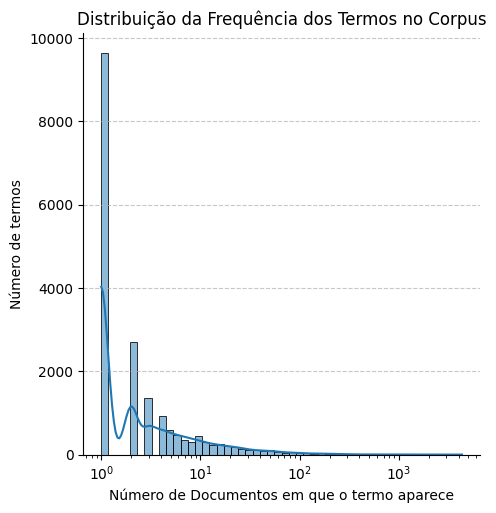

In [21]:
# plotando o histrogama da frequência dos termos
sns.displot(df_vocab, x=df_vocab['doc_freq'], kde=True, bins=50, log_scale=(True, False))
plt.ylabel('Número de termos')
plt.xlabel('Número de Documentos em que o termo aparece')
plt.title('Distribuição da Frequência dos Termos no Corpus')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

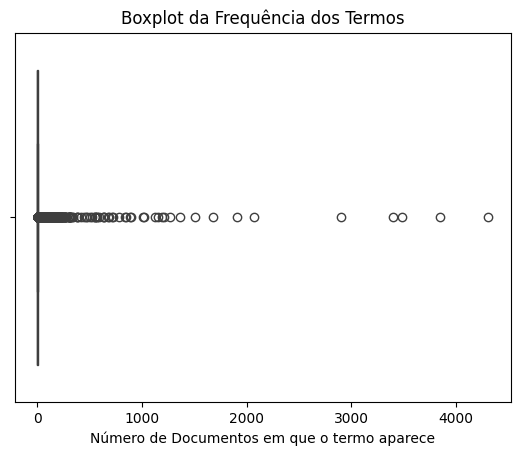

In [22]:
sns.boxplot(x=df_vocab['doc_freq'])
plt.xlabel('Número de Documentos em que o termo aparece')
plt.title('Boxplot da Frequência dos Termos')
plt.show()

In [23]:
vectorizer = TfidfVectorizer(min_df = MIN_DF)
X = vectorizer.fit_transform(sample["tokens"].apply(lambda tokens: " ".join(tokens)))
X.shape

(6072, 6836)

In [24]:
tfidf_matrix = pd.DataFrame(X.todense(), columns = vectorizer.get_feature_names_out())
tfidf_matrix

,aaron,aback,abandon,abbess,abbi,abduct,abductor,abe,abil,abl,...,yugoslavia,yuppi,zani,zatoichi,zealand,zero,zombi,zoo,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Redução de dimensionalidade, via Truncated SVD

In [25]:
n_components_full = X.shape[1]
svd_full = TruncatedSVD(n_components=n_components_full)
svd_full.fit(X)

TruncatedSVD(n_components=6836)

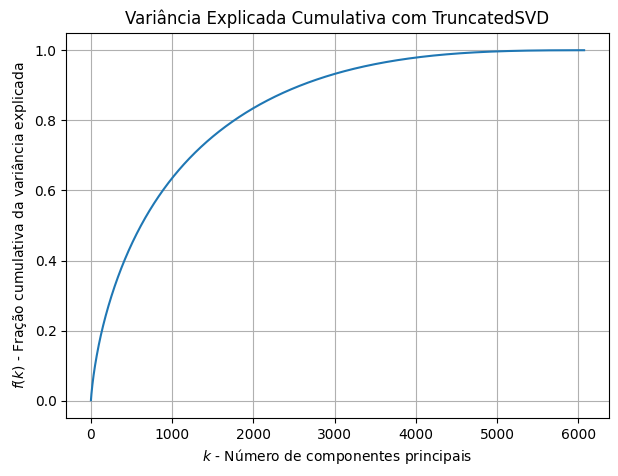

In [26]:
# plotando a variância cumulativa
cumulative_variance = np.cumsum(svd_full.explained_variance_ratio_)

plt.figure(figsize=(7, 5))
plt.plot(np.arange(1, min(X.shape[0], X.shape[1]) + 1), cumulative_variance)
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada')
plt.title('Variância Explicada Cumulativa com TruncatedSVD')
plt.grid(True)
plt.show()

In [27]:
new_n_components = 3000
svd = TruncatedSVD(n_components=new_n_components)
X2 = svd.fit_transform(X)
X2

array([[ 0.10669721, -0.05615992, -0.00695342, ...,  0.00057427,
         0.00246627, -0.00068164],
       [ 0.05572841, -0.04233608,  0.00916699, ...,  0.00108941,
        -0.0007897 ,  0.00143342],
       [ 0.0784418 ,  0.01066507, -0.00956292, ..., -0.00708535,
         0.00370329,  0.00033584],
       ...,
       [ 0.15568488,  0.1171092 ,  0.17381013, ..., -0.00075147,
        -0.01271911, -0.00357138],
       [ 0.03266925, -0.03561273, -0.0111112 , ..., -0.00258929,
        -0.01720054, -0.00500135],
       [ 0.12402589,  0.11766362, -0.03689653, ...,  0.00212026,
         0.00177005, -0.00550446]], shape=(6072, 3000))

In [28]:
X2.shape

(6072, 3000)

#### Normalização

In [29]:
normalizer = Normalizer(norm='l2')
X_normalized = normalizer.fit_transform(X2.copy())
X_normalized

array([[ 0.1104603 , -0.05814061, -0.00719865, ...,  0.00059452,
         0.00255325, -0.00070568],
       [ 0.05856144, -0.04448829,  0.00963301, ...,  0.00114479,
        -0.00082984,  0.00150629],
       [ 0.08006781,  0.01088615, -0.00976115, ..., -0.00723223,
         0.00378005,  0.00034281],
       ...,
       [ 0.16371343,  0.12314843,  0.18277339, ..., -0.00079023,
        -0.01337502, -0.00375555],
       [ 0.03402098, -0.03708625, -0.01157093, ..., -0.00269643,
        -0.01791223, -0.00520829],
       [ 0.13025636,  0.12357448, -0.03875003, ...,  0.00222678,
         0.00185897, -0.00578098]], shape=(6072, 3000))

#### Definindo K do KMeans

##### Inércia

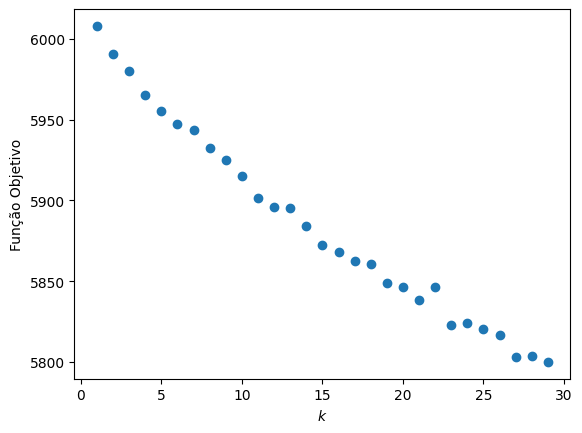

In [30]:
# Inércial
inertia = []
for i in range(1, 30):
  km = KMeans(n_clusters = i)
  km.fit(X_normalized.copy())
  inertia.append(km.inertia_)

# Scatter
plt.scatter(range(1, 30), inertia)
_ = plt.ylabel("Função Objetivo")
_ = plt.xlabel(r"$k$")

##### Silhueta V2

For n_clusters = 6 The average silhouette_score is : 0.003078365590243003
For n_clusters = 7 The average silhouette_score is : 0.0032137137432137358
For n_clusters = 8 The average silhouette_score is : 0.0038966344724607506
For n_clusters = 9 The average silhouette_score is : 0.004092204475189339
For n_clusters = 10 The average silhouette_score is : 0.004317871184419001
For n_clusters = 11 The average silhouette_score is : 0.004637639612197616
For n_clusters = 12 The average silhouette_score is : 0.004807862457536902
For n_clusters = 13 The average silhouette_score is : 0.004992996946427062
For n_clusters = 14 The average silhouette_score is : 0.005273039174834565
For n_clusters = 15 The average silhouette_score is : 0.005420225492096817
For n_clusters = 16 The average silhouette_score is : 0.005362336380729346


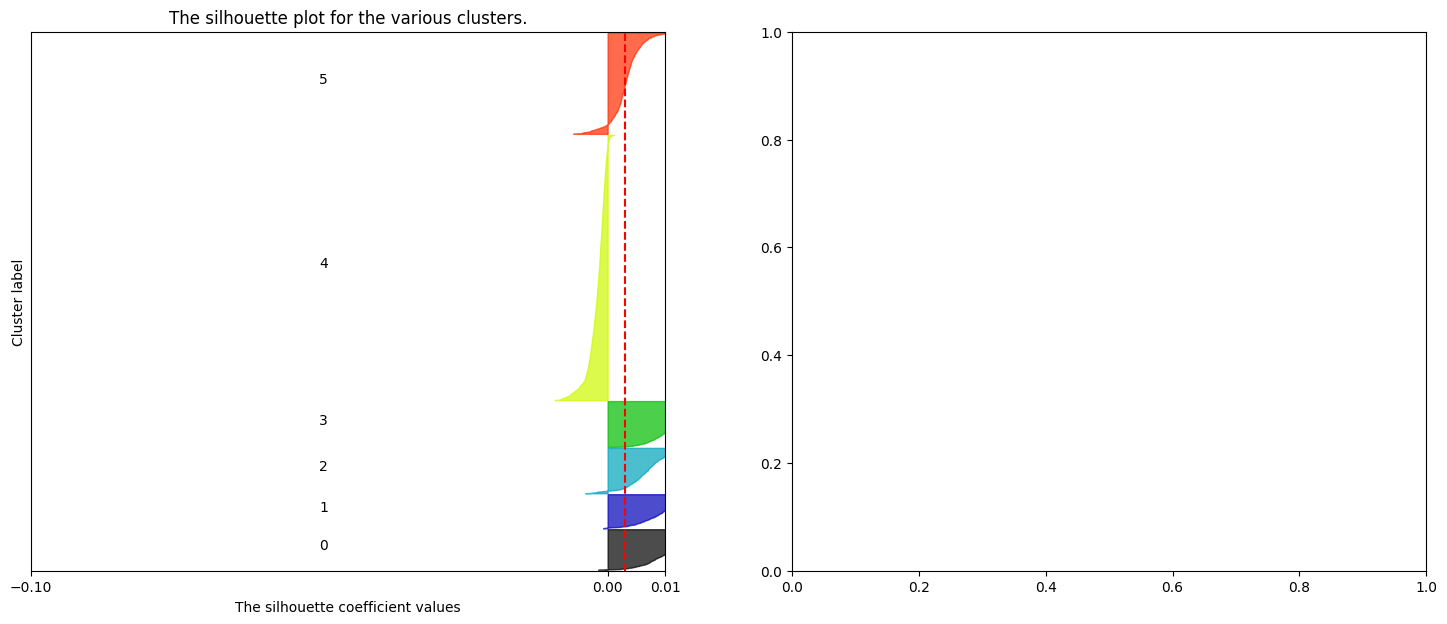

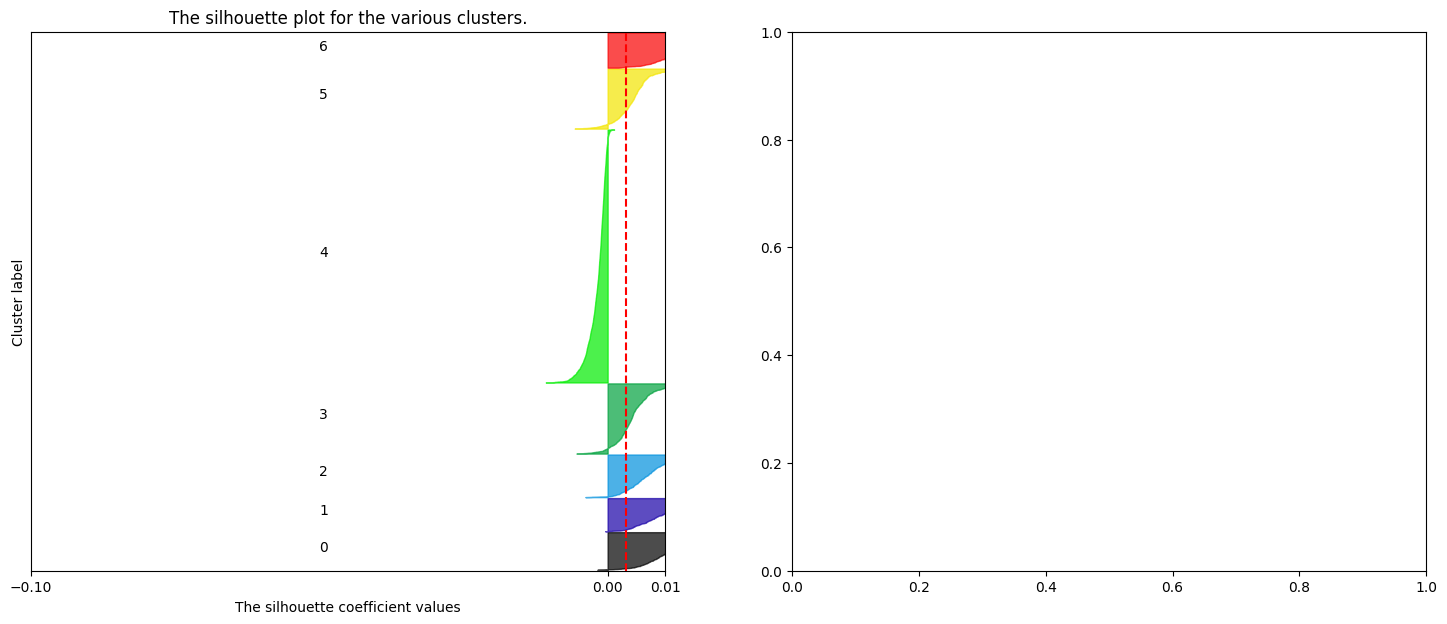

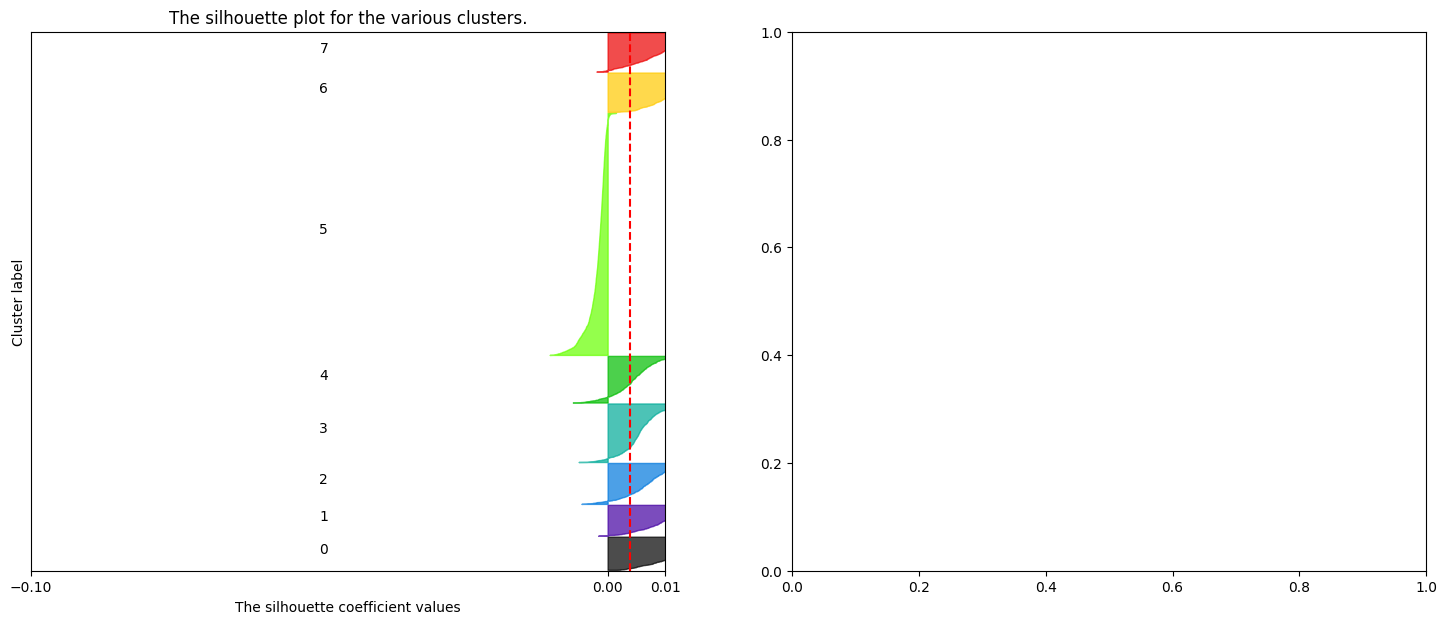

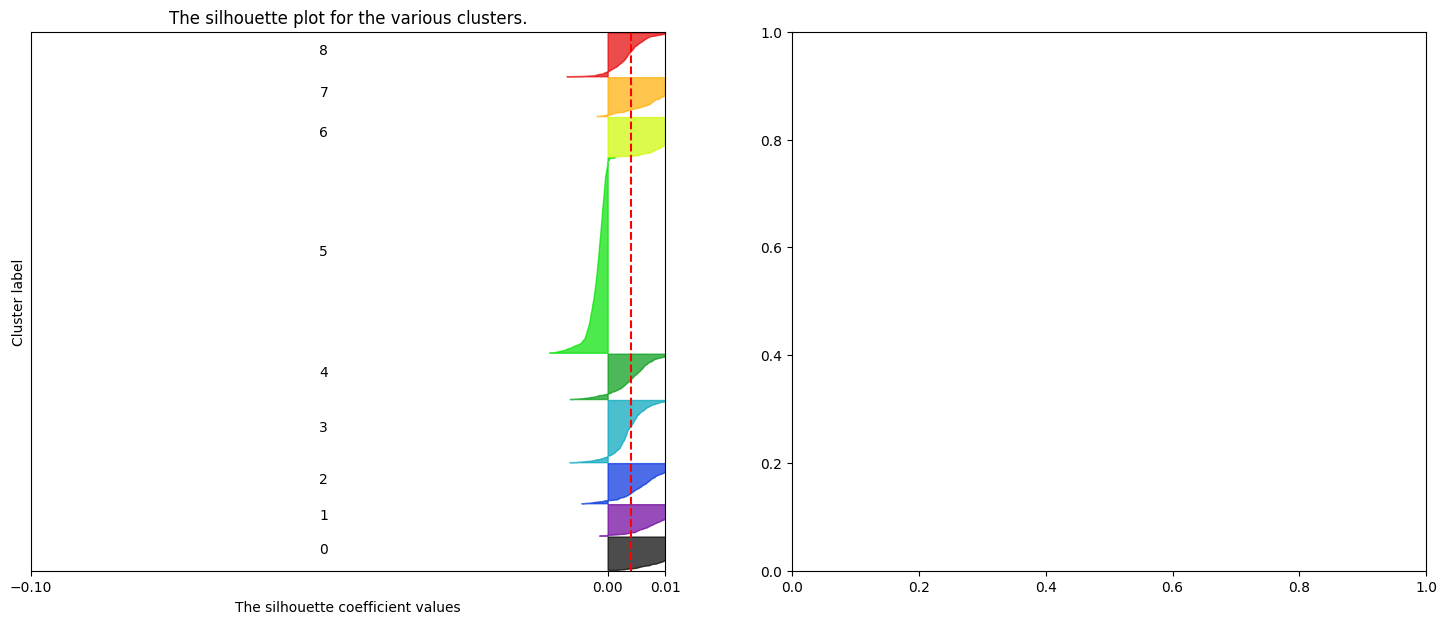

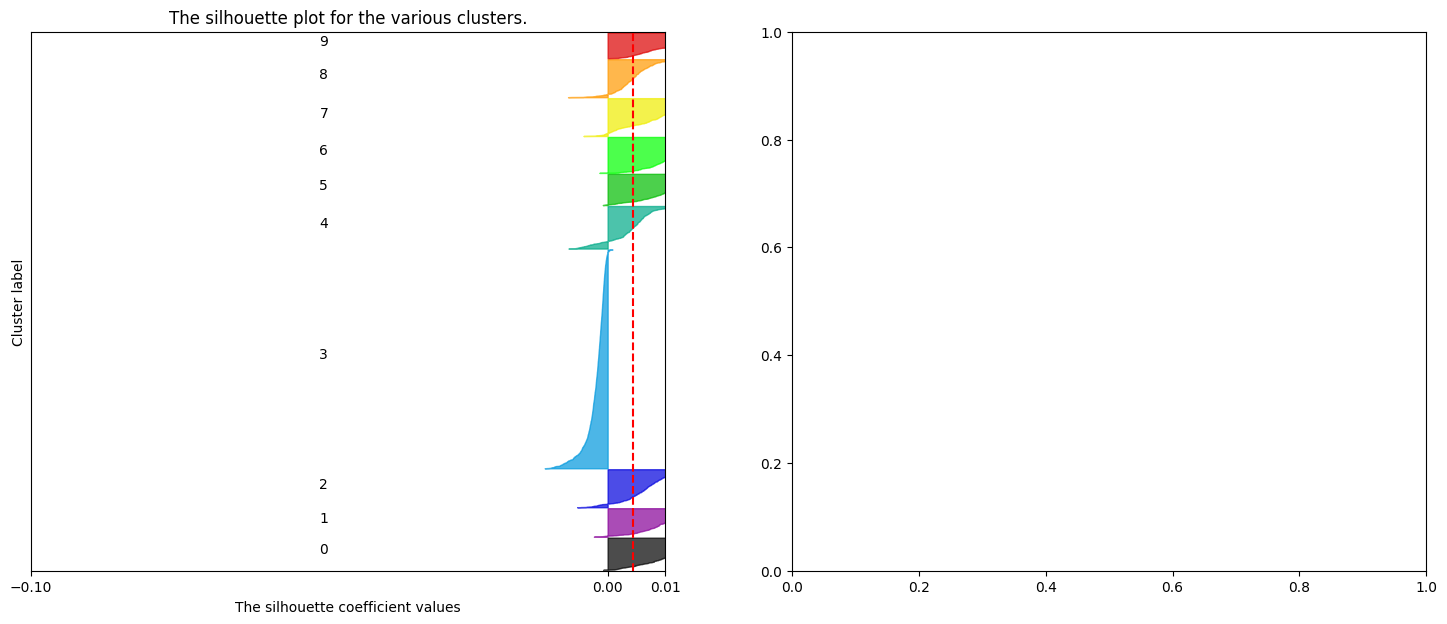

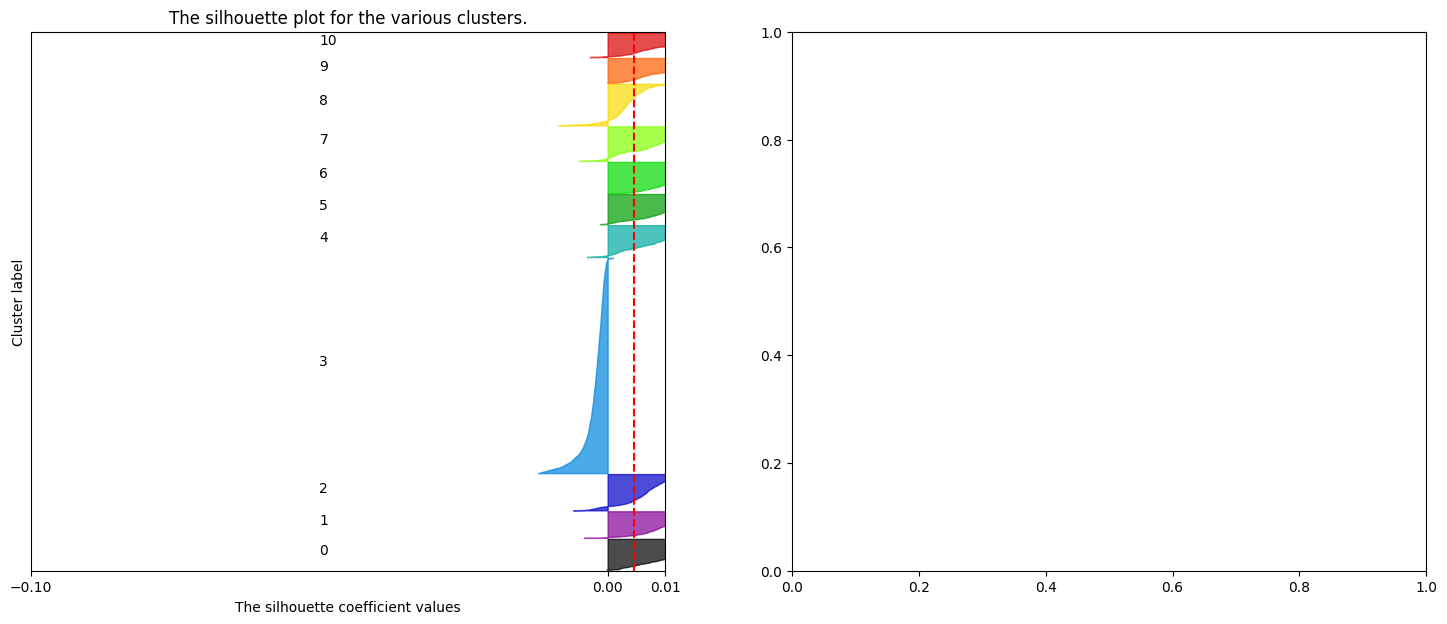

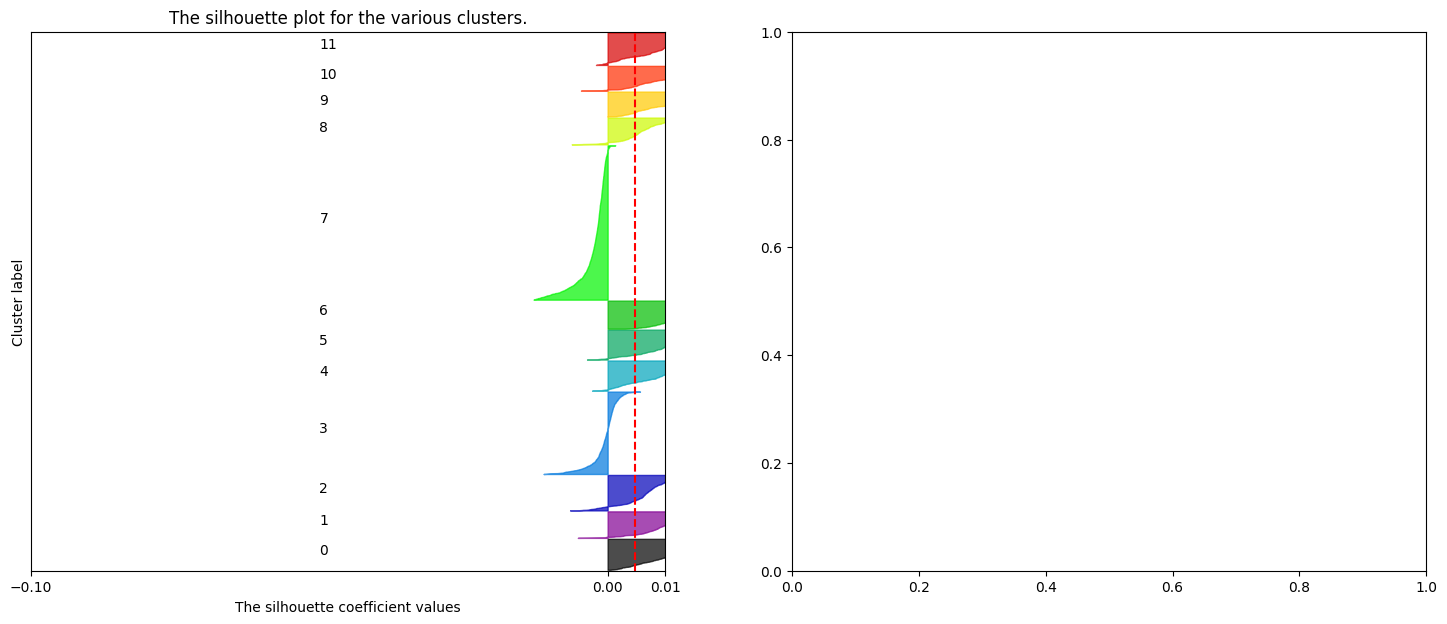

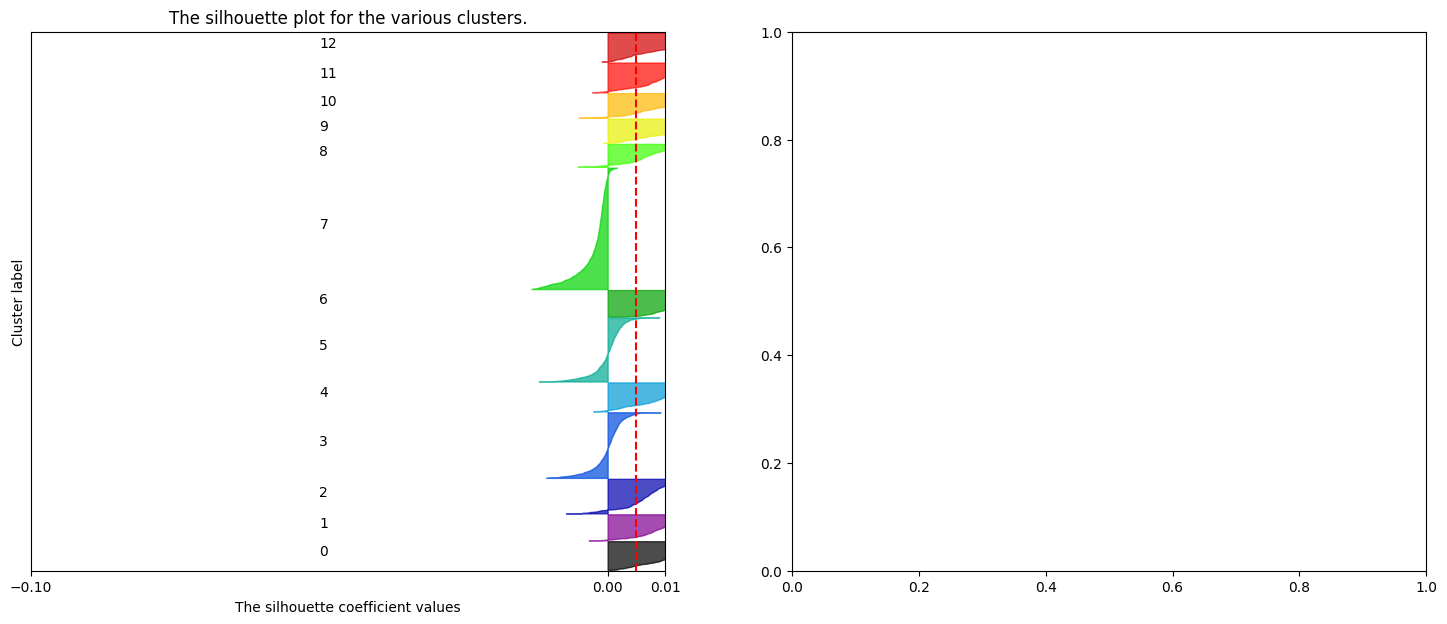

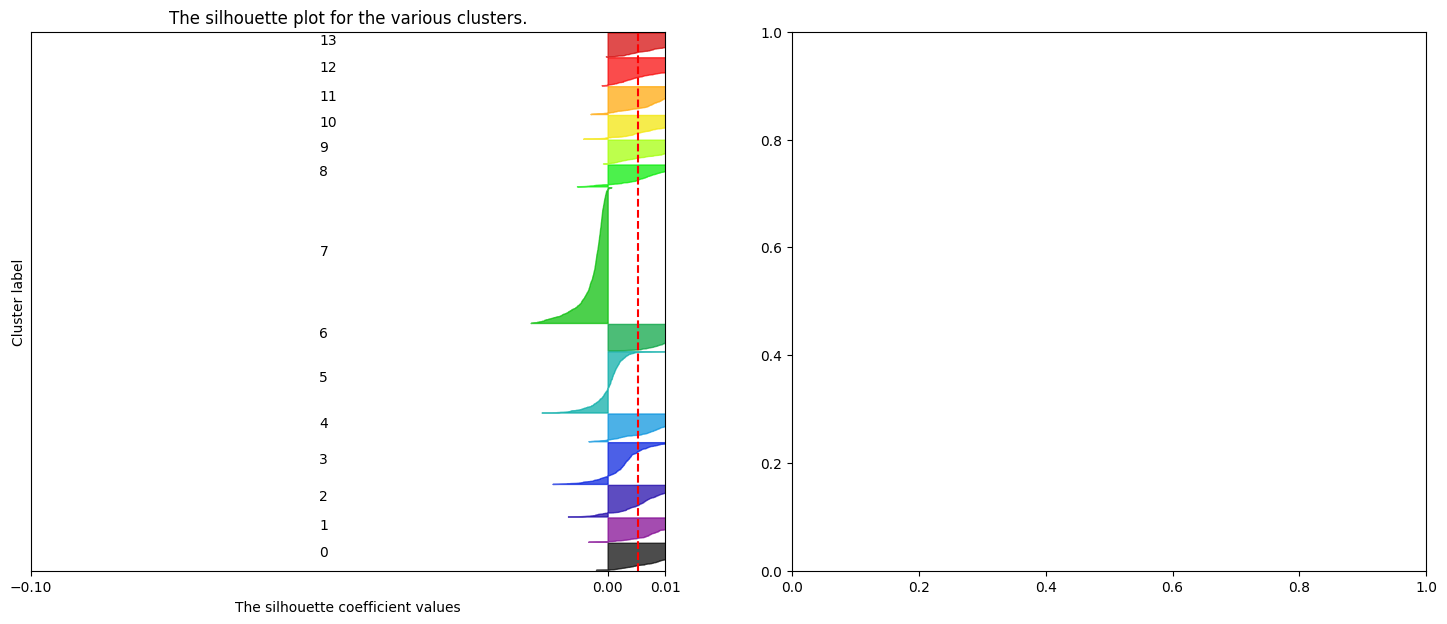

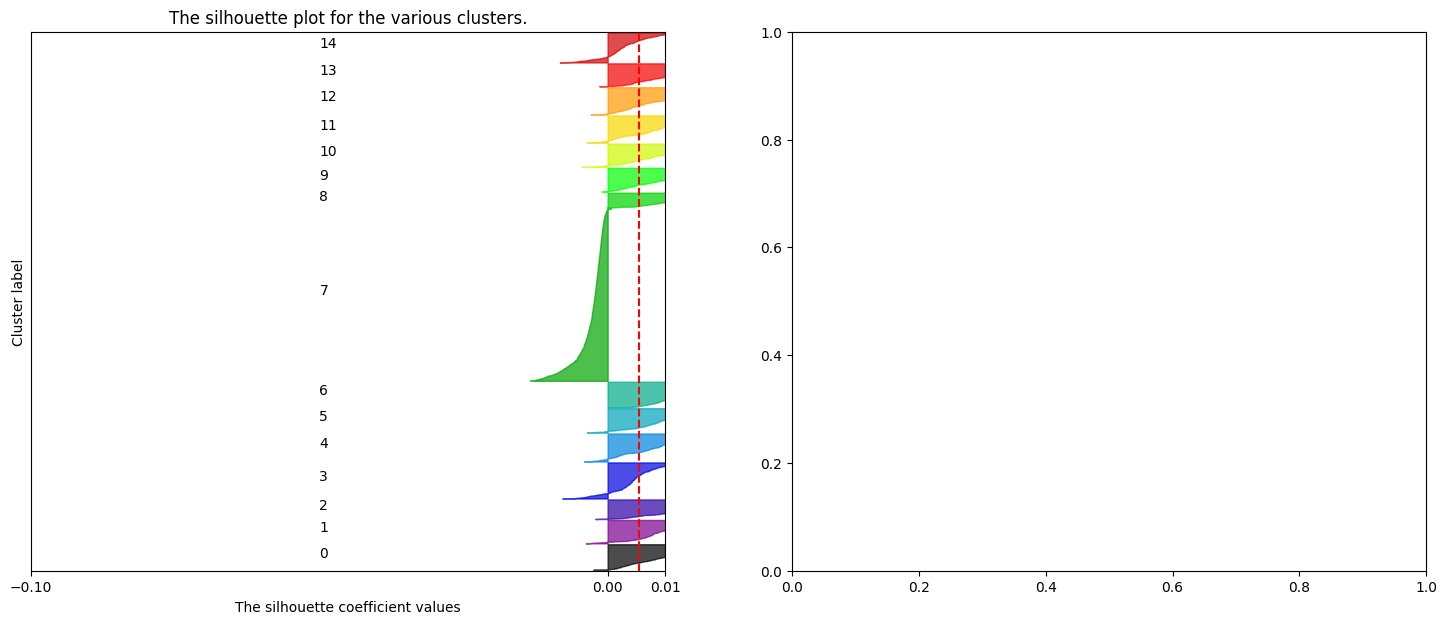

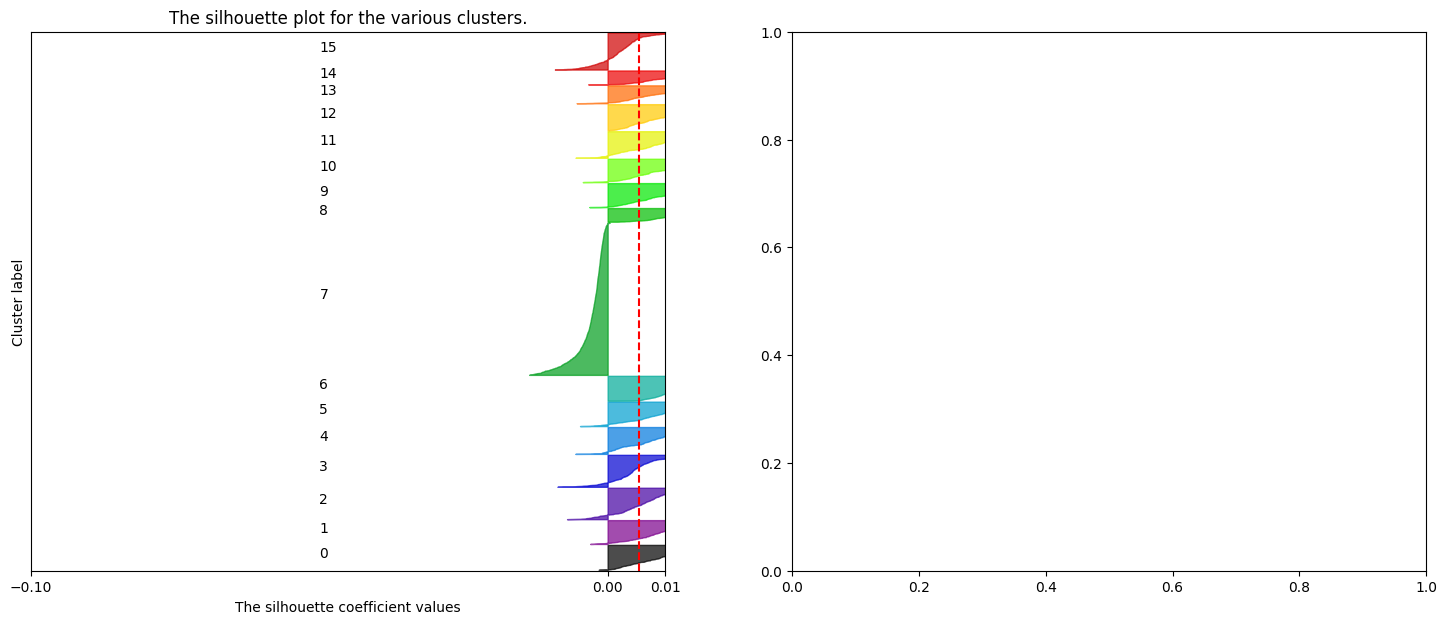

In [31]:
Xs = X_normalized.copy()

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 0.01])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Xs) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Xs)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Xs, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Xs, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.01])

##### Silhueta V1

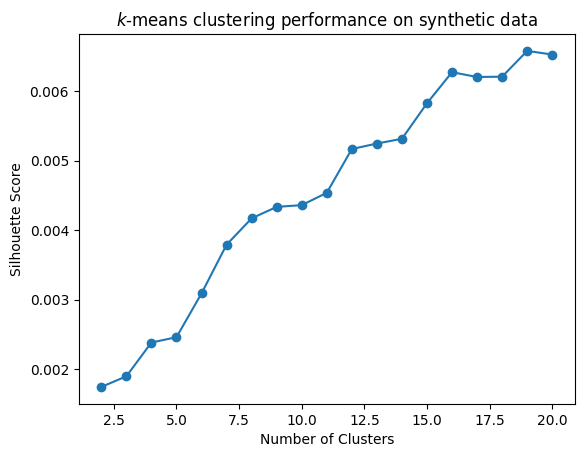

In [32]:
import sklearn.metrics as metrics

def sc_evaluate_clusters(X, max_clusters, n_init, seed):
    s = np.zeros(max_clusters+1)
    s[0] = 0
    s[1] = 0
    for k in range(2, max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters = k, n_init = n_init, random_state = seed)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X, kmeans.labels_, metric = 'euclidean')
    return s

s = sc_evaluate_clusters(X_normalized.copy(), 20, 10, 1)
plt.plot(range(2, len(s)), s[2:], 'o-')
plt.xlabel('Number of Clusters')
plt.title('$k$-means clustering performance on synthetic data')
plt.ylabel('Silhouette Score');

#### KMeans

In [33]:
# Clusterização
kmeans = KMeans(n_clusters = K_KMEANS)
kmeans.fit(X_normalized.copy())


y_kmeans = kmeans.predict(X_normalized.copy())  # neste caso ele esta reprevendo os rotulos dos dados de treinamento, pois essa função é pra predizer novos dados
# ou y_means = kmeans.labels_ # Pega os rotulos dos dados de treinamento

# Vetor com os clusters de cada sinopse
y_kmeans

array([4, 4, 6, ..., 1, 4, 5], shape=(6072,), dtype=int32)

In [34]:
# Reduzindo dimensionalidade para o plot
pca = PCA(n_components=3)
X2_reduced = pca.fit_transform(X_normalized.copy())
X2_reduced

array([[-0.04203779,  0.00934079,  0.01110499],
       [-0.05264667,  0.01125035,  0.0570292 ],
       [ 0.00465353, -0.01615801, -0.04976579],
       ...,
       [ 0.17362977,  0.15346721, -0.02773846],
       [-0.06029553, -0.0213378 ,  0.02727644],
       [ 0.12505646, -0.06391482,  0.06346071]], shape=(6072, 3))

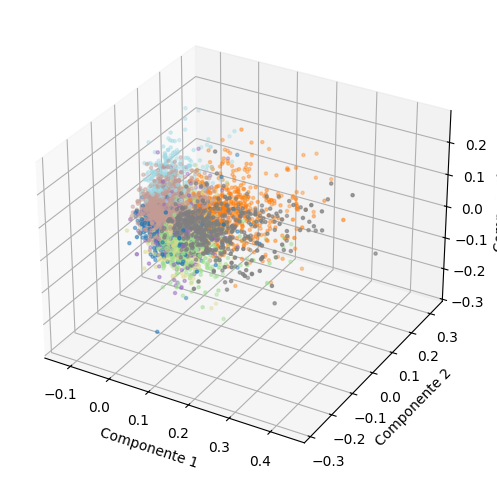

In [35]:
# Plotando  clusters em 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X2_reduced[:, 0], X2_reduced[:, 1], X2_reduced[:, 2], c=y_kmeans, cmap=plt.cm.tab20, s=5)

# Rótulos dos eixos
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')

# plt.xlabel('Componente 1')
# plt.ylabel('Componente 2')
# plt.title('Visualização dos Clusters com KMeans')
# plt.colorbar(label='Cluster', ticks=range(20))
# plt.grid(True)
plt.show()

##### Frequência de Gêneros em cada Cluster

In [36]:
# Criando nova coluna com os clusters
sample_kmeans = sample.copy()
sample_kmeans["cluster"] = y_kmeans
sample_kmeans

,sinopse,tokens,genres,cluster
21377,"Mike Braxton (Sam Jones) a St. Louis cop, rece...","[mike, braxton, sam, jone, st, loui, cop, rece...",Action,4
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...","Crime,Romance,Horror",4
8341,A couple struggles to visit all four of their ...,"[coupl, struggl, visit, four, divorc, parent, ...",Romance,6
14092,"Chaos ensues when a lethal, airborne virus inf...","[chao, ensu, lethal, airborn, viru, infect, po...","Crime,Action",4
12135,Josh's girlfriend wants to get married. Molly'...,"[josh, girlfriend, want, get, marri, molli, bo...",Romance,3
...,...,...,...,...
24560,"A 17-year-old dancer joins a ""thinspiration"" w...","[dancer, join, thinspir, websit, devot, almost...",Biography,0
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...","Sport,Romance",2
24943,A young woman Sasha meets a hippie leader and ...,"[young, woman, sasha, meet, hippi, leader, fin...",Romance,1
12923,Reporter Homer Smith accidentally draws Marcia...,"[report, homer, smith, accident, draw, marcia,...",Musical,4


In [37]:
# Separando Generos agrupados nas linhas
sample_kmeans["genres"] = sample_kmeans["genres"].str.split(',')
sample_kmeans = sample_kmeans.explode("genres")
sample_kmeans

,sinopse,tokens,genres,cluster
21377,"Mike Braxton (Sam Jones) a St. Louis cop, rece...","[mike, braxton, sam, jone, st, loui, cop, rece...",Action,4
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Crime,4
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Romance,4
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Horror,4
8341,A couple struggles to visit all four of their ...,"[coupl, struggl, visit, four, divorc, parent, ...",Romance,6
...,...,...,...,...
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...",Sport,2
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...",Romance,2
24943,A young woman Sasha meets a hippie leader and ...,"[young, woman, sasha, meet, hippi, leader, fin...",Romance,1
12923,Reporter Homer Smith accidentally draws Marcia...,"[report, homer, smith, accident, draw, marcia,...",Musical,4


In [38]:
# Agregando por (cluster + genero) para descobrir frequencia
genre_frequency_kmeans = sample_kmeans.groupby(["genres", "cluster"]).size().reset_index(name="freq")
genre_frequency_kmeans

# Transformando amostra em formato matricial
df_pivot_kmeans = genre_frequency_kmeans.pivot_table(index='genres', columns='cluster', values='freq', fill_value=0)
df_pivot_kmeans = df_pivot_kmeans.astype(int)

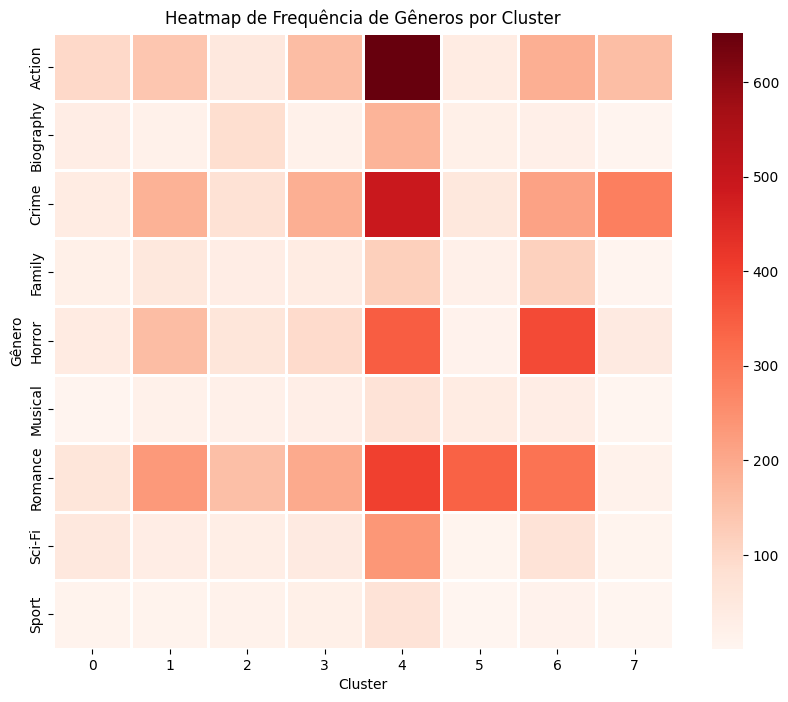

In [39]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_pivot_kmeans, cmap="Reds", linewidths=1)
plt.title('Heatmap de Frequência de Gêneros por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Gênero')
plt.show()

#### Definindo K do Espectral

##### Eigengap

Text(0, 0.5, 'Autovalor')

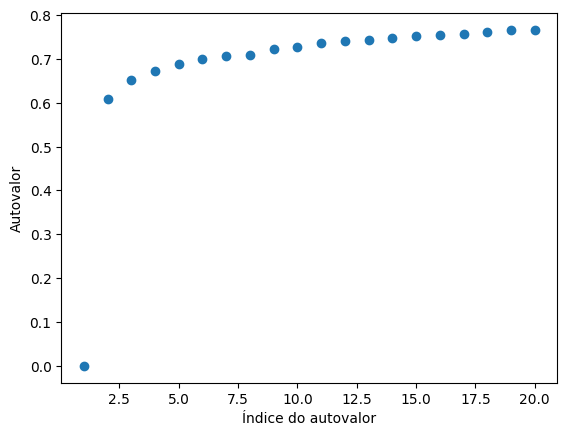

In [40]:
# 1 Construindo a matriz de adjacências do grafo de vizinhos mais próximos.
G = kneighbors_graph(X_normalized.copy(), n_neighbors = 300, include_self = True)
A = 0.5 * (G + G.T)

# 2 Construindo a Laplaciana Normalizada
L = csgraph.laplacian(A, normed = True).todense()

# 3 Obtendo os autovalores da Laplaciana Normalizada
# Valores já estão ordenados em ordem crescente.
values, _ = LA.eigh(L)

# 4 Plotando os valores dos 'gaps' e escolhendo um k adequado.
plt.scatter([i for i in range(1, 21)], values[:20])
plt.xlabel('Índice do autovalor')
plt.ylabel('Autovalor')

#### Agrupamento Espectral

In [41]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=K_SPECTRAL, assign_labels='discretize', random_state=0).fit(X_normalized.copy())
spectral.labels_

array([1, 4, 2, ..., 3, 5, 0], shape=(6072,))

In [42]:
sample_spectral = sample.copy()
sample_spectral["cluster"] = spectral.labels_
sample_spectral

,sinopse,tokens,genres,cluster
21377,"Mike Braxton (Sam Jones) a St. Louis cop, rece...","[mike, braxton, sam, jone, st, loui, cop, rece...",Action,1
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...","Crime,Romance,Horror",4
8341,A couple struggles to visit all four of their ...,"[coupl, struggl, visit, four, divorc, parent, ...",Romance,2
14092,"Chaos ensues when a lethal, airborne virus inf...","[chao, ensu, lethal, airborn, viru, infect, po...","Crime,Action",5
12135,Josh's girlfriend wants to get married. Molly'...,"[josh, girlfriend, want, get, marri, molli, bo...",Romance,1
...,...,...,...,...
24560,"A 17-year-old dancer joins a ""thinspiration"" w...","[dancer, join, thinspir, websit, devot, almost...",Biography,5
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...","Sport,Romance",2
24943,A young woman Sasha meets a hippie leader and ...,"[young, woman, sasha, meet, hippi, leader, fin...",Romance,3
12923,Reporter Homer Smith accidentally draws Marcia...,"[report, homer, smith, accident, draw, marcia,...",Musical,5


In [43]:
# Separando Generos agrupados nas linhas
sample_spectral["genres"] = sample_spectral["genres"].str.split(',')
sample_spectral = sample_spectral.explode("genres")
sample_spectral

,sinopse,tokens,genres,cluster
21377,"Mike Braxton (Sam Jones) a St. Louis cop, rece...","[mike, braxton, sam, jone, st, loui, cop, rece...",Action,1
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Crime,4
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Romance,4
16221,Fervidly dark lovesick horror inspired by the ...,"[fervidli, dark, lovesick, horror, inspir, rea...",Horror,4
8341,A couple struggles to visit all four of their ...,"[coupl, struggl, visit, four, divorc, parent, ...",Romance,2
...,...,...,...,...
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...",Sport,2
24083,When a fiercely competitive 30 year old rower ...,"[fierc, competit, year, old, rower, fail, make...",Romance,2
24943,A young woman Sasha meets a hippie leader and ...,"[young, woman, sasha, meet, hippi, leader, fin...",Romance,3
12923,Reporter Homer Smith accidentally draws Marcia...,"[report, homer, smith, accident, draw, marcia,...",Musical,5


In [44]:
genre_frequency_spectral = sample_spectral.groupby(["genres", "cluster"]).size().reset_index(name="freq")
genre_frequency_spectral

,genres,cluster,freq
0,Action,0,50
1,Action,1,202
2,Action,2,59
3,Action,3,131
4,Action,4,168
...,...,...,...
67,Sport,3,11
68,Sport,4,1
69,Sport,5,56
70,Sport,6,29


In [45]:
df_pivot_spectral = genre_frequency_spectral.pivot_table(index='genres', columns='cluster', values='freq', fill_value=0)
df_pivot_spectral = df_pivot_spectral.astype(int)

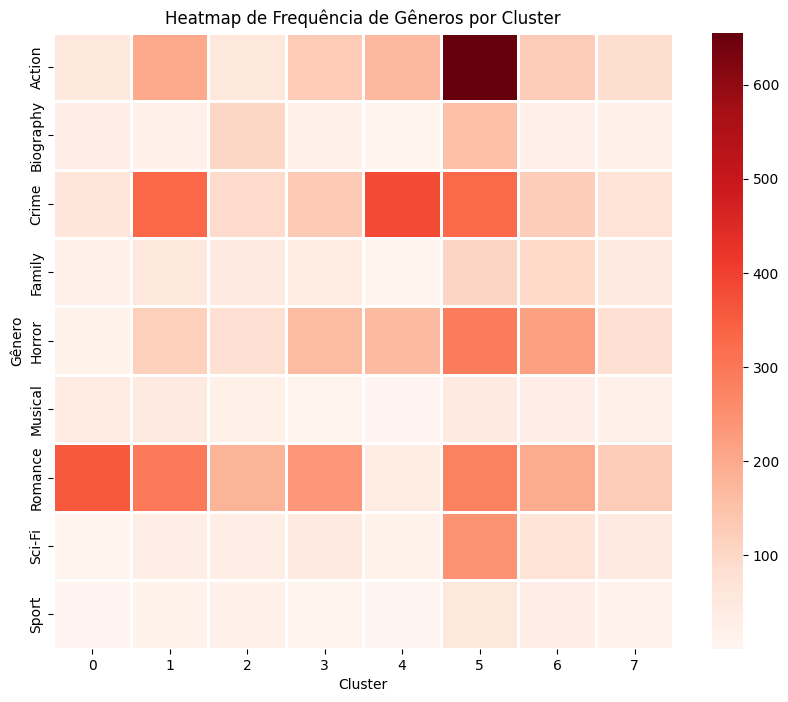

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_pivot_spectral, cmap="Reds", linewidths=1)
plt.title('Heatmap de Frequência de Gêneros por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Gênero')
plt.show()

## Considerações Finais

### Interpretação

texto aqui

### Validação

O trabalho deve conter resultados mostrando que os algoritmos (e respectivos parâmetros) foram escolhidos e utilizados de forma correta. Entre os pontos importantes:
1. Como foi escolhido o número de componentes principais para o PCA? O número de componentes principais tem um impacto significativo nos resultados? É necessário usar PCA neste trabalho?
2. Como o número de grupos para cada algoritmo de agrupamento foi definido? A escolha do algoritmo de agrupamento impacta significativamente os resultados? E o número de grupos?

Fará parte da avaliação a forma que escolherem para validar a metodologia. Vocês podem recorrer a visualizações interessantes, medidas internas...

### Análise

Após validar e entender os resultados (e se convencerem que estão corretos e fazem sentido), você deve responder as perguntas principais:
- Há diferença nas distribuições de gêneros dos filmes em grupos diferentes?
- Há relação entre as sinopses dos filmes e os respectivos gêneros?

- **Opcional, pontuação extra:** se, além das sinopses, você também considerar as demais informações no conjunto de dados (avaliações, atores/atrizes, diretores(as), título, ano e duração) para os algoritmos de agrupamento, é possível encontrar uma melhor associação entre os grupos e os gêneros dos filmes?
Novamente, recorra às ferramentas que já vimos no curso para responder essa pergunta: visualizações, medidas externas... **soluções que tiverem achados interessantes nessa parte do trabalho ganharão ponto extra**.